# Library Imports

In [122]:
# import necessary libraries
from random import sample
from collections import Counter, namedtuple
from typing import List, Dict
from pprint import pprint

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plot

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

In [124]:
# Fixed random state number for reproducibility
RANDOM_STATE = 4400

# Make sure any numpy randomness is also reproducible
np.random.seed(RANDOM_STATE)

# Container for model errors during evaluation
Error = namedtuple("Error", ["train", "validation", "test"])

# Parsing and Cleaning Data

In [3]:
file_name = "SpotifyFeatures.csv"
spotify_data = pd.read_csv(file_name)
spotify_data.dropna()
spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232725 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

In [4]:
def get_counter_from_column(dataframe: pd.DataFrame, column: str) -> Counter:
    unique = Counter(dataframe[column])
    return unique

# getting an idea of what non-numerical values we might have for data so we can map them to numbers later
# excluding things such as artist_name, track_name, and track_id due to the sheer size and number of unique elements
column_names = ["genre", "key", "mode", "time_signature"]
unique_genres, unique_keys, unique_modes, unique_time_signatures = [get_counter_from_column(spotify_data, column) for column in column_names]

print(f"Unique values for genre: {unique_genres}")
print(f"Unique values for key: {unique_keys}")
print(f"Unique values for mode: {unique_modes}")
print(f"Unique values for time signature: {unique_time_signatures}")

Unique values for genre: Counter({'Comedy': 9681, 'Soundtrack': 9646, 'Indie': 9543, 'Jazz': 9441, 'Pop': 9386, 'Electronic': 9377, 'Children’s Music': 9353, 'Folk': 9299, 'Hip-Hop': 9295, 'Rock': 9272, 'Alternative': 9263, 'Classical': 9256, 'Rap': 9232, 'World': 9096, 'Soul': 9089, 'Blues': 9023, 'R&B': 8992, 'Anime': 8936, 'Reggaeton': 8927, 'Ska': 8874, 'Reggae': 8771, 'Dance': 8701, 'Country': 8664, 'Opera': 8280, 'Movie': 7806, "Children's Music": 5403, 'A Capella': 119})
Unique values for key: Counter({'C': 27583, 'G': 26390, 'D': 24077, 'C#': 23201, 'A': 22671, 'F': 20279, 'B': 17661, 'E': 17390, 'A#': 15526, 'F#': 15222, 'G#': 15159, 'D#': 7566})
Unique values for mode: Counter({'Major': 151744, 'Minor': 80981})
Unique values for time signature: Counter({'4/4': 200760, '3/4': 24111, '5/4': 5238, '1/4': 2608, '0/4': 8})


In [5]:
def remove_data_with_values(dataframe: pd.DataFrame, column_name: str, values: List[str]) -> pd.DataFrame:
    criteria = lambda row: row[column_name] not in values
    return dataframe[dataframe.apply(criteria, axis=1)]

def create_integer_mapping(items: List[str]) -> Dict[str, int]:
    return {item: i for i, item in enumerate(items)}

def replace_values(dataframe: pd.DataFrame, values_to_merge: List[str], new_value: str) -> pd.DataFrame:
    return dataframe.copy().replace(to_replace=values_to_merge, value=new_value)

# remove rows that have a 0/4 time signature 
time_signatures_to_remove = ["0/4"]
spotify_data_removed = remove_data_with_values(spotify_data, "time_signature", time_signatures_to_remove)

# remove rows that have the genre of acapella, children's music, comedy
genres_to_remove = ["A Capella", "Children's Music", 'Children’s Music', "Comedy"]
spotify_data_removed = remove_data_with_values(spotify_data_removed, "genre", genres_to_remove)

# merge rap and hip-hop genres
spotify_data_merged = replace_values(spotify_data_removed, ["Rap", "Hip-Hop"], "Rap/Hip-Hop")
# merge movie and soundtrack genres
spotify_data_merged = replace_values(spotify_data_merged, ["Movie", "Soundtrack"], "Movie/Soundtrack")
# merge reggae and reggaeton genres
spotify_data_merged = replace_values(spotify_data_merged, ["Reggae", "Reggaeton"], "Reggae/Reggaeton")

unique_genres, unique_keys, unique_modes, unique_time_signatures = [get_counter_from_column(spotify_data_merged, column) for column in column_names]

genre_integer_mapping = create_integer_mapping(list(unique_genres))
key_integer_mapping = create_integer_mapping(list(unique_keys))
mode_integer_mapping = create_integer_mapping(list(unique_modes))
time_signature_mapping = create_integer_mapping(list(unique_time_signatures))

print(f"Genre to integer mapping: {genre_integer_mapping}")
print(f"Key to integer mapping: {key_integer_mapping}")
print(f"Mode to integer mapping: {mode_integer_mapping}")
print(f"Time signature to integer mapping: {time_signature_mapping}")

Genre to integer mapping: {'Movie/Soundtrack': 0, 'R&B': 1, 'Alternative': 2, 'Country': 3, 'Dance': 4, 'Electronic': 5, 'Anime': 6, 'Folk': 7, 'Blues': 8, 'Opera': 9, 'Rap/Hip-Hop': 10, 'Indie': 11, 'Classical': 12, 'Pop': 13, 'Reggae/Reggaeton': 14, 'Jazz': 15, 'Rock': 16, 'Ska': 17, 'Soul': 18, 'World': 19}
Key to integer mapping: {'C#': 0, 'F#': 1, 'C': 2, 'F': 3, 'G': 4, 'E': 5, 'D#': 6, 'G#': 7, 'D': 8, 'A#': 9, 'A': 10, 'B': 11}
Mode to integer mapping: {'Major': 0, 'Minor': 1}
Time signature to integer mapping: {'4/4': 0, '5/4': 1, '3/4': 2, '1/4': 3}


In [6]:
# replace values based on a list of dictionary mappings
def replace_mappings(dataframe: pd.DataFrame, mappings: List[Dict[str, int]]) -> pd.DataFrame:
    merged_mapping = {}
    new_dataframe = dataframe.copy()
    for mapping in mappings:
        merged_mapping.update(mapping)
    new_dataframe = new_dataframe.replace(to_replace=merged_mapping)
    return new_dataframe

# use the mappings from the previous cell and show that the only rows with a non-integer/float datatype are artist_name, track_name, and track_id
spotify_data_replaced = replace_mappings(spotify_data_merged, [genre_integer_mapping, key_integer_mapping, mode_integer_mapping, time_signature_mapping])
spotify_data_replaced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208162 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             208162 non-null  int64  
 1   artist_name       208162 non-null  object 
 2   track_name        208162 non-null  object 
 3   track_id          208162 non-null  object 
 4   popularity        208162 non-null  int64  
 5   acousticness      208162 non-null  float64
 6   danceability      208162 non-null  float64
 7   duration_ms       208162 non-null  int64  
 8   energy            208162 non-null  float64
 9   instrumentalness  208162 non-null  float64
 10  key               208162 non-null  int64  
 11  liveness          208162 non-null  float64
 12  loudness          208162 non-null  float64
 13  mode              208162 non-null  int64  
 14  speechiness       208162 non-null  float64
 15  tempo             208162 non-null  float64
 16  time_signature    20

In [7]:
# drop a given list of column names from a dataframe
def drop_columns(dataframe: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    new_dataframe = dataframe.copy()
    for column in columns:
        new_dataframe = new_dataframe.drop(column, 1)
    return new_dataframe

# create our array of target variables
Y = spotify_data_replaced["genre"]

# drop genres, artist names, track names, and track ids from dataframe
spotify_data_dropped = drop_columns(spotify_data_replaced, ["genre", "artist_name", "track_name", "track_id"])

# create our array of samples and variables
X = spotify_data_dropped.to_numpy()

/var/folders/61/75f500n904z_fc_50gvpf_t80000gn/T/ipykernel_5073/3373698099.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  new_dataframe = new_dataframe.drop(column, 1)


# Visualizing Data

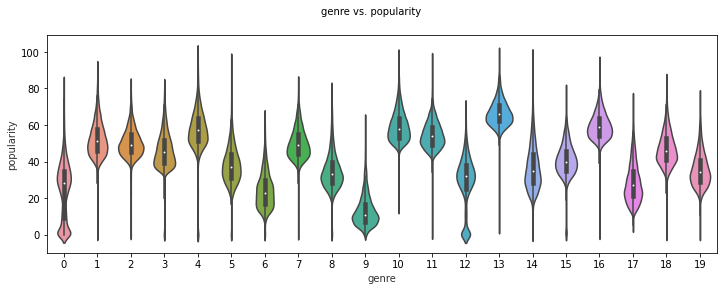

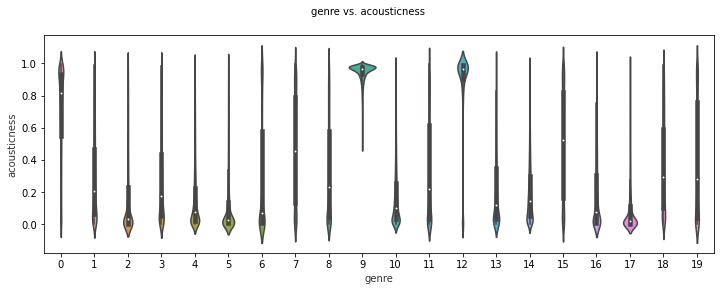

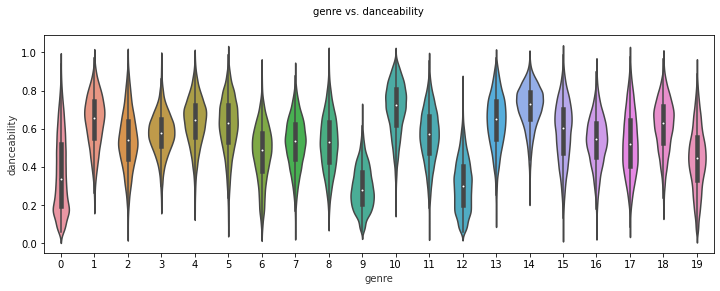

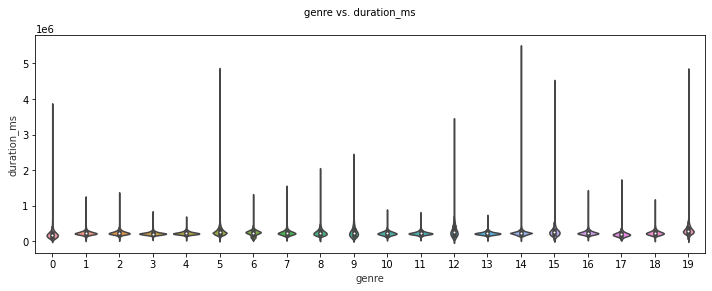

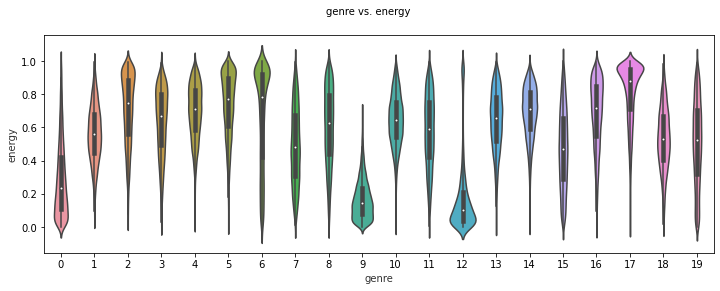

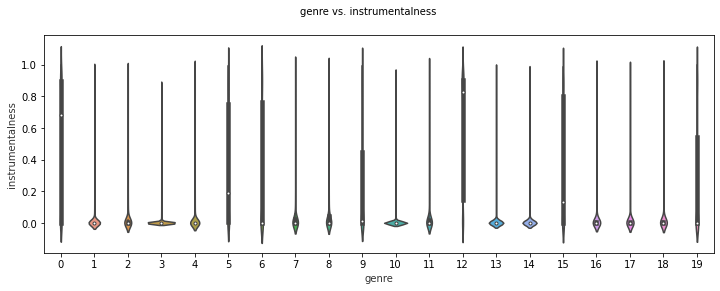

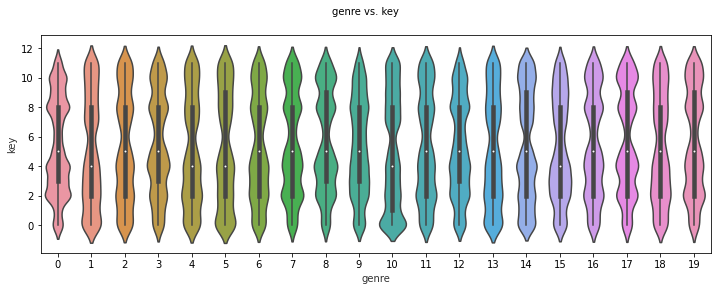

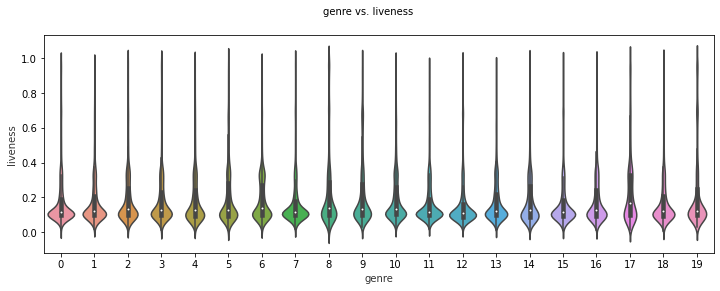

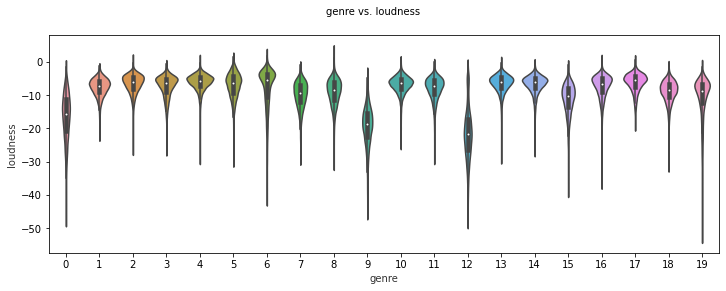

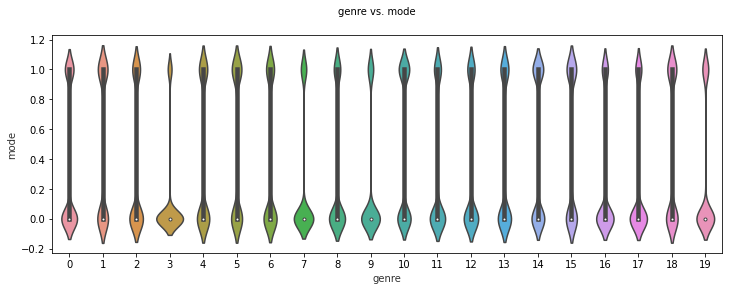

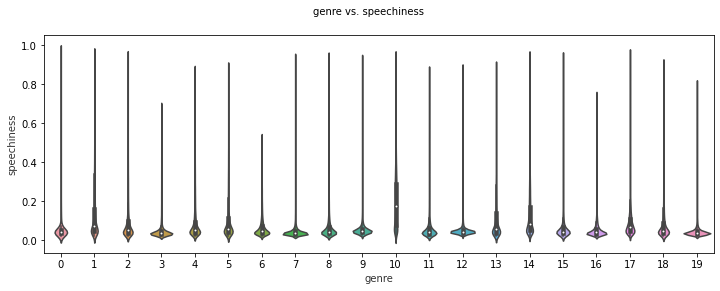

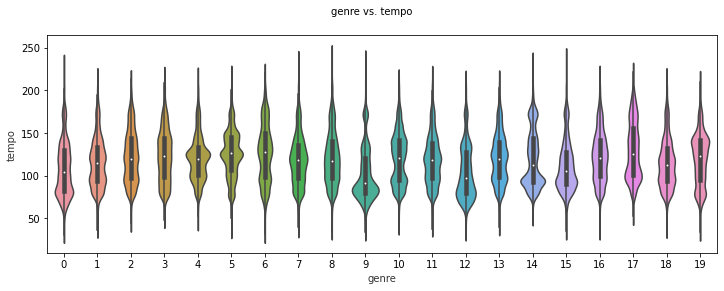

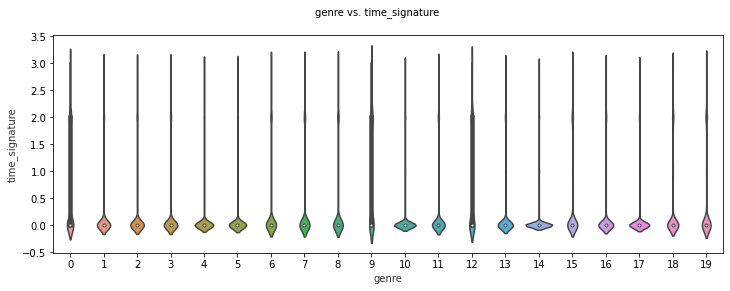

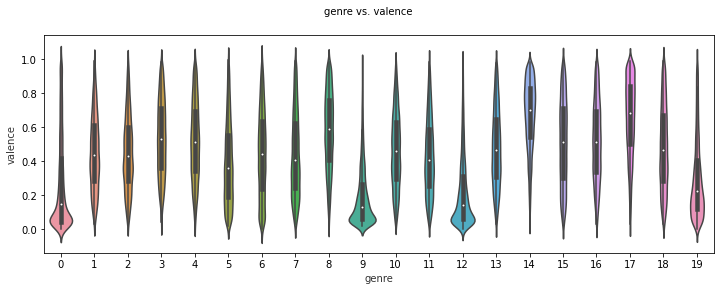

In [8]:
def violin_plot(x: str, y: str, data: pd.DataFrame):
    f, (ax) = plot.subplots(1, 1, figsize = (12, 4))
    f.suptitle(f"{x} vs. {y}", fontsize = 10)

    sns.violinplot(x=x, y=y, data=data, ax=ax)
    ax.set_xlabel(x, size = 10, alpha = 0.8)
    ax.set_ylabel(y, size = 10, alpha = 0.8)

    plot.savefig(f"data_vis/{x}_vs_{y}.png")

attributes = ["popularity", "acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "time_signature", "valence"]
for attribute in attributes:
    violin_plot("genre", attribute, spotify_data_replaced)

## Formatting Data

In [9]:
# standardizing our data using a scaler
scaler = StandardScaler()
# scale our data
X_scaled = scaler.fit_transform(X)

# transform our data
num_components = 10
transformer = PCA(n_components=num_components, whiten=True)
X_transformed = transformer.fit_transform(X_scaled)

In [10]:
# split our data into testing and training splits
test_ratio = 0.25

X_sampled, Y_sampled = resample(X_transformed, Y, n_samples=100000, random_state=RANDOM_STATE)

X_train, X_test, Y_train, Y_test = train_test_split(X_sampled, Y_sampled, test_size=test_ratio, random_state=RANDOM_STATE)
print(f"Size of training set: {len(X_train)} / {len(X_sampled)} = {100 * len(X_train) / len(X_sampled):0.2f}%")
print(f"Size of testing set: {len(X_test)} / {len(X_sampled)} = {100 * len(X_test) / len(X_sampled):0.2f}%")

Size of training set: 75000 / 100000 = 75.00%
Size of testing set: 25000 / 100000 = 25.00%


# Setup for Hyperparameter Tuning

In [37]:
# Hyperparameter tuning grids for GridSearchCV, for each model
SVC_PARAM_GRID = {
    "C": [1.0, 0.1, 0.01, 0.001],
    "class_weight": [None, "balanced"],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "max_iter": [10, 100, 1000],
}

KNN_PARAM_GRID = {
    "algorithm": ["ball_tree", "kd_tree"],
    "metric": ["minkowski", "euclidean"],
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"],
}

SGD_PARAM_GRID = {
    "alpha": [0.001, 0.01, 1],
    "class_weight": [None, "balanced"],
    "max_iter": [1000],
    "penalty": ["l2", "elasticnet"],
}

In [38]:
# Define each model using GridSearchCV for hyperparameter tuning
svc_clf = GridSearchCV(SVC(random_state=RANDOM_STATE), 
                       SVC_PARAM_GRID,
                       return_train_score=True)
knn_clf = GridSearchCV(KNeighborsClassifier(), 
                       KNN_PARAM_GRID, 
                       return_train_score=True)
log_sgd_clf = GridSearchCV(SGDClassifier(loss="log", random_state=RANDOM_STATE),
                          SGD_PARAM_GRID,
                          return_train_score=True)

## Training our Models
    WARNING: This cell takes a LONG (see: hours) time to run.

In [ ]:
def train_model(model, features, target, model_name: str) -> None:
    print(f"Training: {model_name}...")
    model.fit(features, target)
    print(f"Completed training for: {model_name}\n")
    
#############
#  Train a Support Vector Machine
############
train_model(svc_clf, features=X_train, target=Y_train, model_name="SVC")

############
# Train a k-Nearest Neighbors Classifier
############
train_model(knn_clf, features=X_train, target=Y_train, model_name="KNN")

############
# Train a Logistic Regression model using SGD
############
train_model(log_sgd_clf, features=X_train, target=Y_train,
            model_name="Logistic Regression (SGDClassifier)")

# Model Evaluation

In [129]:
def evaluate_model(model, features, target, model_name: str) -> Error:
    print(f"Evaluating Model: {model_name}...\n")
    
    # GridSearchCV saves training scores in a numpy matrix
    df_cv_results = pd.DataFrame(model.cv_results_)
    train_err = 1 - df_cv_results[df_cv_results.params == model.best_params_]["mean_train_score"][0]
    
    validation_err = 1 - model.best_score_ # Mean cross-validated score of the optimal estimator
    test_err = 1 - model.score(features, target)  # Score on the testing set
    
    print("Optimal Hyperparameters: ")
    pprint(model.best_estimator_.get_params())
    print()
    
    print(f"Training Error: {train_err: .3%}")
    print(f"Validation Error: {validation_err: .3%}")
    print(f"Testing Error: {test_err: .3%}")
        
    print(f"\nCompleted Evaluation for: {model_name}\n")    
    return Error(train=train_err, validation=validation_err, test=test_err)

svc_err = evaluate_model(svc_clf, X_test, Y_test, "Support Vector Machine Classifier")
print('-'*50)
knn_err = evaluate_model(knn_clf, X_test, Y_test, "k-Nearest Neighbors Classifier")
print('-'*50)
log_sgd_err = evaluate_model(log_sgd_clf, X_test, Y_test, "Logistic Regression (SGDClassifier)")

Evaluating Model: Support Vector Machine Classifier...

Optimal Hyperparameters: 
{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 3,
 'p': 2,
 'weights': 'uniform'}

Training Error:  41.370%
Validation Error:  69.712%
Testing Error:  40.496%

Completed Evaluation for: Support Vector Machine Classifier

--------------------------------------------------
Evaluating Model: k-Nearest Neighbors Classifier...

Optimal Hyperparameters: 
{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 3,
 'p': 2,
 'weights': 'uniform'}

Training Error:  41.370%
Validation Error:  69.712%
Testing Error:  40.496%

Completed Evaluation for: k-Nearest Neighbors Classifier

--------------------------------------------------
Evaluating Model: Logistic Regression (SGDClassifier)...

Optimal Hyperparameters: 
{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 '

In [15]:
# TODO -- Reuse?

integer_genre_mapping = {v:k for k, v in genre_integer_mapping.items()}

# TODO: random KeyErrors when doing random samples 🤨
def predict_random_samples(x: np.ndarray, y: np.ndarray, count: int) -> None:
    for index in np.random.choice(len(x), count):
        features = x[index].reshape(1, -1)
        expected = y[index]
        prediction = model.predict(features)
        print(f"Features: {features}\tExpected: {integer_genre_mapping[expected]}\tPredicted: {integer_genre_mapping[prediction[0]]}\tCorrect={(expected == prediction)[0]}")

predict_random_samples(X_transformed, Y, 10)

Features: [[-1.17397671 -0.45510077 -0.07795308  0.53537021 -0.95929539 -1.42340965
   0.68689681  0.62515518  0.76269217 -0.84776176]]	Expected: Jazz	Predicted: Reggae/Reggaeton	Correct=False
Features: [[-0.58732506 -1.12429042 -0.25614586 -2.04043135  1.01526432  1.33910357
   1.46926412  1.89641687 -1.112213   -0.04762822]]	Expected: Classical	Predicted: Rap/Hip-Hop	Correct=False
Features: [[ 0.99514679  0.85196622  0.54304527  1.93305039  2.08631756 -0.5449352
   1.62507844  0.45166214  0.36732935 -0.67983257]]	Expected: Folk	Predicted: Folk	Correct=True
Features: [[-9.04035894e-01 -2.64329789e-01 -2.68954162e-01  8.78384530e-01
  -8.87012927e-01 -3.76332016e-01  1.10416986e+00  8.34902223e-04
  -1.39649436e-01  5.35480062e-01]]	Expected: Dance	Predicted: Indie	Correct=False
Features: [[-0.44302268 -1.01668494  0.46140207  0.16322707  0.10357792 -0.83039838
  -1.46937524  0.37282776  1.41717245  0.27619435]]	Expected: Ska	Predicted: Reggae/Reggaeton	Correct=False
Features: [[-0.658